# Fetch the data of friends from the API Key




In [ ]:
#This is the code to fetch the data of the friends from the api key of lastfm
#-------------------------------------------------------------------------------------------

import requests
import json
import csv

API_KEY = "d1bac1a21f6c7411208a615747599b02"
username = "rj"

start_timestamp = '1609459200' # 01-01-2021 00:00:00 in Unix timestamp format
end_timestamp = '1612137600' # 01-02-2021 00:00:00 in Unix timestamp format

method = 'user.getrecenttracks'

with open("friend.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["username", "friend"])
    url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={username}&api_key={API_KEY}&format=json"
    response = requests.get(url)
    data = json.loads(response.text)
    friends = data["friends"]["user"]
    
    for friend in friends:
        friend_username = friend["name"]
        url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={friend_username}&api_key={API_KEY}&format=json"
        response = requests.get(url)
        data = json.loads(response.text)
        if(data.get('error')==6):
              continue
        friend_friends = data["friends"]["user"]

#Fetching each friend's friend data
        for friend_friend in friend_friends:
            friend_friend_username = friend_friend["name"]
            writer.writerow([friend_username,friend_friend_username])

#Fetching track list data of each user and their friends

In [ ]:
#This is the code to fetch the data from the api key of lastfm of tracks listened by each user and his friends in 4 months
#-----------------------------------------------------------------------------------------------------------------------------------

import pandas as pd
import requests
import json
import csv

API_KEY = "d1bac1a21f6c7411208a615747599b02"
username = "rj"

start_timestamp = '1610200678' #09-01-2021 1:57:58 in Unix Timestamp Format
end_timestamp = '1617976678' #09-04-2021 1:57:58 in Unix Timestamp Format

# start_timestamp = '1654783078' #09-06-2022 1:57:58 in Unix Timestamp Format
# end_timestamp = '1670594278' #09-12-2022 1:57:58 in Unix Timestamp Format

method = 'user.getrecenttracks'
dataframe = pd.read_csv('friends_data.csv')
friends=dataframe['friend']
data1 = friends.drop_duplicates()
print(len(data1))
with open("yeardata_track_data.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["username", "artist","tracks","album","date"])
    
    for friend in data1:
        page_num = 1
        total_pages = 1
        while page_num <= total_pages:
            params = {
                'api_key': API_KEY,
                'user': friend,
                'method': method,
                'limit': 200,
                'page': page_num,
                'from': start_timestamp,
                'to': end_timestamp,
                'format': 'json'
            }    
            responsetracks = requests.get('http://ws.audioscrobbler.com/2.0/', params=params)
            data = json.loads(responsetracks.text)
            
            if(data.get('error')==17):
                writer.writerow([friend])
                print(dataframe['friend'])
                break
                
            if 'recenttracks' in data:
                total_pages = int(data['recenttracks']['@attr']['totalPages'])
                
                for track in data['recenttracks']['track']:
                    if('date' in track):
                        writer.writerow([friend, track['artist']['#text'], track['name'], track['album']['#text'], track['date']['#text']])
                        
            page_num += 1

#Determining Threshold

Jan


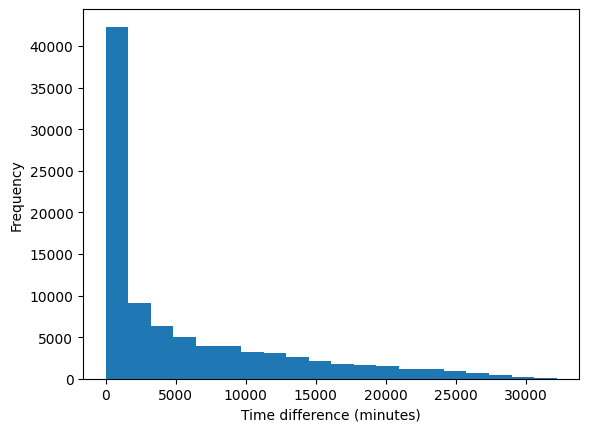

New threshold: 5526.385138310546 minutes
Feb


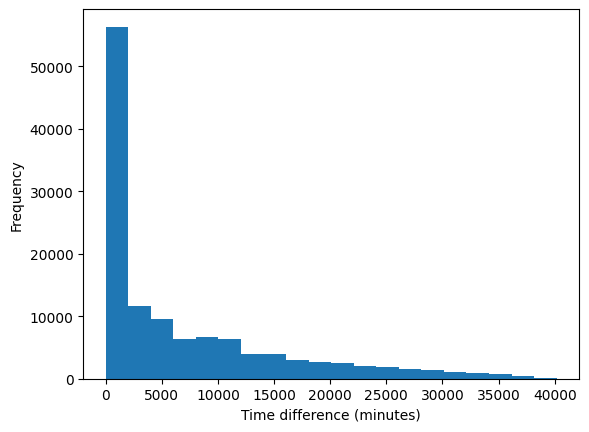

New threshold: 6796.50348639939 minutes
Mar


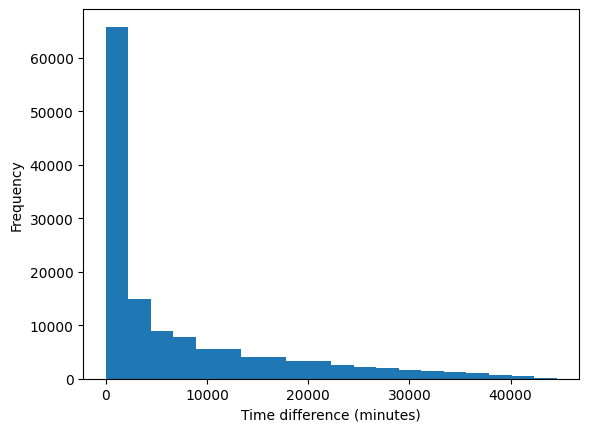

New threshold: 7130.527973125936 minutes
Apr


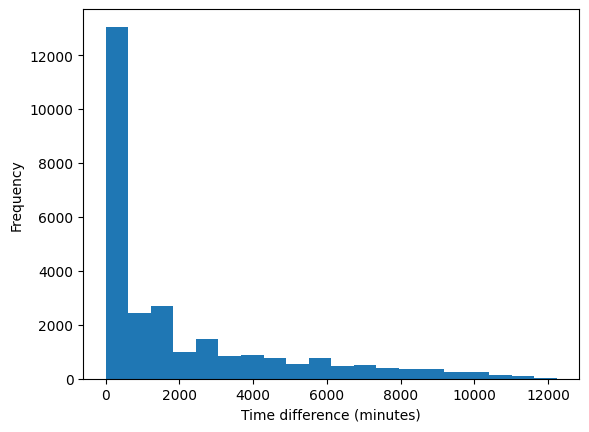

New threshold: 1992.9000953218947 minutes
average threshold: 5361.579173289441 minutes


In [6]:
#This is the code to determine the threshold for influence, month wise, take average for every month, and take average of every average.
#--------------------------------------------------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


songs_df = pd.read_csv('quarterly_yeardata_track_data.csv')

#Empty array for storing the time differences
time_diffs = []

#Everyday Thresholds
thresholds = []

data2 = songs_df["date"].str.split(',', expand=True)
data7 = songs_df['date'].str.split(' ',expand=True)
data7.rename(columns = {0:'day', 1:'month', 2:'year',3:'time'}, inplace=True)
data5 = data7["time"].str.split(':', expand=True)
data5.rename(columns = {0:'hour',1:'minute'}, inplace=True)
data3=songs_df['username']
data4=songs_df['tracks']
data1=pd.concat([data3,data4,data5,data7], axis=1)
hashtable={1:'Jan',2:'Feb',3:'Mar',4:'Apr'}
# hashtable={1:'Jun',2:'Jul',3:'Aug',4:'Sep',5:'Oct',6:'Nov',7:'Dec'}

for i in range(1,len(hashtable)+1):
  string = str(hashtable[i]) 
  print(string)
  data = data1[data1.month == string]
  grouped_df = data.groupby('tracks')
  time_diffs=[]

  # Loop through each group and compare the timestamp of each user's listening event with their friend's listening event
  for song, group in grouped_df:
      user1 = None
      user2 = None
      for i, row in group.iterrows():
          if user1 is None:
              user1 = row
          elif user2 is None:
              user2 = row
          else:
              # Calculate the time difference between the two user's listening activity in days
              time_diff_days = abs((int(user1['hour']) - int(user2['hour']))*60 + (int(user1['minute']) - int(user2['minute'])) + (int(user1['day']) - int(user2['day']))*1440)
              time_diffs.append(time_diff_days)
              user1 = row
              user2 = None
  thresholds.append(np.mean(time_diffs))

  # Plot a histogram of the time differences
  plt.hist(time_diffs, bins=20)
  plt.xlabel('Time difference (minutes)')
  plt.ylabel('Frequency')
  plt.show()

  # Calculate the average time difference 
  new_threshold = np.mean(time_diffs)
  if(len(time_diffs)==0):
    continue
  else:
    thresholds.append(new_threshold)
  print(f'New threshold: {new_threshold} minutes')
avg_threshold = np.mean(thresholds)
print(f'average threshold: {avg_threshold} minutes')

# Conversion to csv of users and time differences

In [11]:
#This is the code to make csv file for user1, user2 and time difference 
#-------------------------------------------------------------------------------

import csv

with open("quarter_year_edge_weight.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Source", "target","edge_attr"])

    for song, group in grouped_df:
        user1 = None
        user2 = None
        for i, row in group.iterrows():
            if user1 is None:
                user1 = row
            elif user2 is None:
                user2 = row
                if(user1['username']!=user2['username']):
                  print(user2)
                else:
                  user2=None
            else:
                time_diff_days = abs((int(user1['hour']) - int(user2['hour']))*60 + (int(user1['minute']) - int(user2['minute'])) + (int(user1['day']) - int(user2['day']))*1440)
                if(time_diff_days <= avg_threshold):
                  writer.writerow([user1['username'], user2['username'], time_diff_days])
                user1 = row
                user2 = None

Streaming output truncated to the last 5000 lines.
day                      06
month                   Apr
year                  2021,
time                  12:12
Name: 1154888, dtype: object
username    OrlandoAKANandy
tracks             Yosemite
hour                     23
minute                   47
day                      08
month                   Apr
year                  2021,
time                  23:47
Name: 1442078, dtype: object
username    Sliders1234
tracks              You
hour                 17
minute               22
day                  07
month               Apr
year              2021,
time              17:22
Name: 164201, dtype: object
username    michalboo
tracks            You
hour               07
minute             50
day                02
month             Apr
year            2021,
time            07:50
Name: 488238, dtype: object
username    erikfrey
tracks           You
hour              02
minute            24
day               03
month            Apr
year 

# Merging the time differences and edge weights

In [12]:
# This is the code to merge the time diff with the friends file and give the edge weights
#----------------------------------------------------------------------------------------------

import pandas as pd

friends = pd.read_csv('friends_data.csv')
weight = pd.read_csv('quarter_year_edge_weight.csv')

# merge the two dataframes 
merged_df = pd.merge(friends, weight, left_on=['username', 'friend'], right_on=['Source', 'target'], how='left')

merged_df.fillna(0, inplace=True)

# adding new column named 'weight'
merged_df['weight'] = 0

# update the weight of the edge by 1 if the time difference is not 0
merged_df.loc[merged_df['edge_attr'] != 0, 'weight'] += 1

#Dropping unwanted columns
merged_df.drop(['Source','target','edge_attr'], axis="columns")

merged_df.to_csv('updated_friends.csv', index=False)






# Direct Influence

In [30]:
# This is the code which calculates influence based on the sum of edge weights
#---------------------------------------------------------------------------------------

import networkx as nx
import pandas as pd

df = pd.read_csv('updated_friends.csv')

# creating a directed graph
G = nx.DiGraph()

for i, row in df.iterrows():
    G.add_edge(row['Source'], row['target'], weight=row['edge_attr'])

#Storing the outdegree and sum of edge weight for each node
node_influence = {}

for node in G.nodes():
    out_degree = G.out_degree(node)
    neighbor_sum = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    node_influence[node] = (out_degree, neighbor_sum)

data69 = pd.DataFrame(node_influence)
data69_1 = data69.transpose()
data69_1.rename(columns = {0:"out_degree",1:"neighbor_sum"}, inplace = True)
data69_2=  data69_1.drop("out_degree",axis=1)
data69_2.sort_values(by="neighbor_sum", ascending= False)

,neighbor_sum
spacedentist-tv,39416.0
bbc1xtra,33796.0
raffy_rillo,33018.0
russx2,27745.0
IM4ttthew,26654.0
...,...
adcubar,0.0
dworqin,0.0
mussin,0.0
msmarypoppins,0.0


# Indirect Influence

In [ ]:
#If you want to do analysis on deepness on the whole dataset

# import sys
# sys.setrecursionlimit(1000) # Set the recursion limit to a large number


In [14]:
# This is the code to calculate indirect influence
#---------------------------------------------------------

import pandas as pd
import networkx as nx
import csv

df = pd.read_csv('updated_friends.csv')

G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

graph = {}

with open('updated_friends.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = row['username']
        target = row['friend']
        weight = float(row['weight'])
        
        if source not in graph:
            graph[source] = []
        graph[source].append((target, weight))

def sum_of_all_paths(node, graph, depth):
    total_weight = 0
    
    # DFS function for traversing the graph
    def dfs(node, current_weight, current_depth):
        nonlocal total_weight

        # Determining the threshold of level of deepeness
        if current_depth > depth:
            return
        
        if node not in graph:
            return
        
        for neighbor, weight in graph[node]:
            total_weight += weight
            dfs(neighbor, current_weight + weight, current_depth + 1)

    # Starting the traversal from the specified node
    dfs(node, 0, 0)
    return total_weight

try:
    deepness_df = pd.read_csv('deepness.csv', index_col='node')
except FileNotFoundError:
    deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2', 'depth_3'])


new_data = []
for node in G.nodes():
    depth_1 = sum_of_all_paths(node, graph, 1)
    depth_2 = sum_of_all_paths(node, graph, 2)
    # depth_3 = sum_of_all_paths(node, graph, 3)
    print(depth_1)
    print(depth_2)
    # print(depth_3)
    new_data.append({'node': node, 'depth_1': depth_1, 'depth_2': depth_2})

    if node not in deepness_df.index:
        deepness_df.loc[node] = [node, depth_1, depth_2]

deepness_df.to_csv('deepness.csv', index=False)
print(deepness_df)


190.0
22223.0
633.0
30971.0
255.0
22960.0
382.0
25179.0
193.0
22226.0
742.0
29077.0
267.0
27975.0
190.0
22223.0
190.0
22223.0
549.0
59528.0
975.0
125151.0
486.0
45894.0
247.0
35851.0
357.0
25223.0
190.0
22223.0
190.0
22223.0
1236.0
218280.0
253.0
35972.0
190.0
22223.0
195.0
22228.0
193.0
22226.0
766.0
129950.0
1433.0
223786.0
612.0
108588.0
1176.0
229109.0
357.0
49484.0
343.0
56874.0
190.0
22223.0
639.0
100641.0
206.0
23007.0
495.0
85422.0
765.0
117032.0
894.0
179885.0
180.0
38316.0
1585.0
266881.0
195.0
22418.0
812.0
120614.0
359.0
63447.0
193.0
22226.0
389.0
62374.0
821.0
142311.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
190.0
22223.0
59.0
6561.0
59.0
6561.0
118.0
20191.0
56.0
13627.0
59.0
6561.0
414.0
43862.0
59.0
6561.0
59.0
6561.0
59.0
6561.0
359.0
68384.0
59.0
6561.0
59.0
6561.0
61.0
6563.0
551.0
75414.0
59.0
6561.0
60.0
6562.0
121.0
8796.0
59.0
6561.0
60.0
6562.0
59.0
6561.0
59.0
6561.0
63.0
6651.0
59.0
6561.

In [ ]:
# This is the code to calculate indirect influence
#---------------------------------------------------------

import pandas as pd
import networkx as nx
import csv

df = pd.read_csv('updated_friends.csv')

G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

graph = {}

with open('updated_friends.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = row['username']
        target = row['friend']
        weight = float(row['weight'])
        
        if source not in graph:
            graph[source] = []
        graph[source].append((target, weight))

def sum_of_all_paths(node, graph, depth):
    total_weight = 0
    
    # DFS function for traversing the graph
    def dfs(node, current_weight, current_depth):
        nonlocal total_weight

        # Determining the threshold of level of deepeness
        if current_depth > depth:
            return
        
        if node not in graph:
            return
        
        for neighbor, weight in graph[node]:
            total_weight += weight
            dfs(neighbor, current_weight + weight, current_depth + 1)

    # Starting the traversal from the root node
    dfs(node, 0, 0)
    return total_weight

try:
    deepness_df = pd.read_csv('deepness_depth3.csv', index_col='node')
except FileNotFoundError:
    deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2', 'depth_3'])


new_data = []
for node in G.nodes():
    depth_1 = sum_of_all_paths(node, graph, 1)
    depth_2 = sum_of_all_paths(node, graph, 2)
    depth_3 = sum_of_all_paths(node, graph, 3)
    print(depth_1)
    print(depth_2)
    print(depth_3)
    new_data.append({'node': node, 'depth_1': depth_1, 'depth_2': depth_2, 'depth_3' : depth_3})

    if node not in deepness_df.index:
        deepness_df.loc[node] = [node, depth_1, depth_2, depth_3]

deepness_df.to_csv('deepness_depth3.csv', index=False)
print(deepness_df)


190.0
22223.0
3146674.0
633.0
30971.0
3665796.0
255.0
22960.0
3224860.0
382.0
25179.0
3379117.0
193.0
22226.0
3146677.0
742.0
29077.0
3878491.0
267.0
27975.0
4058756.0
190.0
22223.0
3146674.0
190.0
22223.0
3146674.0
549.0
59528.0
7367520.0
975.0
125151.0
17032971.0
486.0
45894.0
5294742.0
247.0
35851.0
5219446.0
357.0
25223.0
2204995.0
190.0
22223.0
3146674.0
190.0
22223.0
3146674.0
1236.0
218280.0
38935167.0
253.0
35972.0
5239640.0
190.0
22223.0
3146674.0
195.0
22228.0
3146679.0
193.0
22226.0
3146677.0
766.0
129950.0
21766068.0
1433.0
223786.0
34403848.0
612.0
108588.0
17711224.0
1176.0
229109.0
41785352.0
357.0
49484.0
7192309.0
343.0
56874.0
9435733.0
190.0
22223.0
3146674.0
639.0
100641.0
15852537.0
206.0
23007.0
3271428.0


# Structural Holes

In [20]:
#This is the code to find the structural holes in the network
#-----------------------------------------------------------------

import networkx as nx
import pandas as pd

filename = "quarter_year_edge_weight.csv"
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"{filename} not found. Please provide a valid filename.")
    exit()

try:
    G = nx.from_pandas_edgelist(df, source="Source", target="target", edge_attr="edge_attr")
except nx.NetworkXError:
    print("Failed to create graph from csv file. Check if the columns 'source', 'target', and 'weight' are present.")
    exit()

#Finding the structural hole
scores = nx.constraint(G)
score_arr = []

for node, score in scores.items():
    if(score<=1.0):
        score_arr.append(score)
        print(f"Node {node}: Structural Hole Score {score}")

score_arr.sort()

Node MaxsSelfIsSteam: Structural Hole Score 0.03545583725862306
Node polymorphous71: Structural Hole Score 0.09140885012758887
Node spookycharm: Structural Hole Score 0.04766754188366959
Node Sliders1234: Structural Hole Score 0.04681462270268817
Node fascinated: Structural Hole Score 0.07942776069729497
Node woca: Structural Hole Score 0.023817351448882466
Node BBCRadio3: Structural Hole Score 0.058789697894893585
Node mll: Structural Hole Score 0.03918047053698092
Node dougma: Structural Hole Score 0.024757879992823535
Node 1stepkloser: Structural Hole Score 0.019636370402863687
Node goldfieber: Structural Hole Score 0.034494313854237096
Node Wizpig: Structural Hole Score 0.03538479194537501
Node Mattias92: Structural Hole Score 0.02427652982007087
Node Cloudspotter: Structural Hole Score 0.024808970168458313
Node Biven: Structural Hole Score 0.07026927493559597
Node lordgonz: Structural Hole Score 0.025003487407967057
Node stronzochilegge: Structural Hole Score 0.03039341618776768
N

In [21]:
print(score_arr)

[0.0187572306232994, 0.019636370402863687, 0.019918330221600323, 0.020046689185369088, 0.023717269594621424, 0.023817351448882466, 0.023856566102735798, 0.02427652982007087, 0.024757879992823535, 0.024808970168458313, 0.025003487407967057, 0.02522905670401239, 0.026173048463267973, 0.026462190309643006, 0.026546823392518813, 0.027148031961668408, 0.027682227105617987, 0.027693084893595506, 0.028223227048833475, 0.028371787750655936, 0.02843823213678727, 0.028493954521396334, 0.029037881499631196, 0.029359940087892587, 0.029733674445616944, 0.029748871661134425, 0.030197297082617376, 0.03039341618776768, 0.03062120989544492, 0.03149257316452807, 0.03179570639571552, 0.032000880098975934, 0.03207159366641321, 0.032417349308925085, 0.032610871386485996, 0.03296094675608885, 0.03306219813435159, 0.033077823255771854, 0.033210532960467824, 0.033260351658246465, 0.03328144037933597, 0.03354695226750448, 0.03367047936722889, 0.034494313854237096, 0.034607408247502115, 0.03474452906573822, 0.0

In [22]:
import numpy as np

# calculating the mean and standard deviation 
mean_score = np.sum(score_arr) / len(score_arr)
std_score = (sum((x - mean_score) * 2 for x in score_arr) / len(score_arr)) * 0.5

# setting the threshold as a multiple of the standard deviation above the mean
threshold = mean_score + 2 * std_score

print("Mean score: ", mean_score)
print("Standard deviation: ", std_score)
print("Threshold: ", threshold)

Mean score:  0.14866790706752983
Standard deviation:  -6.454096516487577e-17
Threshold:  0.1486679070675297


In [26]:
ab_threshold = []
for score in score_arr:
  if(score>=threshold):
    ab_threshold.append(score)

print(ab_threshold)

[0.1499940266104006, 0.1500319261018867, 0.15140625, 0.15184059483949264, 0.15222117095160564, 0.15601280671652468, 0.15822975733223574, 0.16095458731674567, 0.16140330078838994, 0.1614623248222535, 0.16666666666666669, 0.16925478703156804, 0.17311554348090819, 0.17376546970995488, 0.174843643249676, 0.1757246267369975, 0.17576611149314936, 0.17633371534853182, 0.17955384625796314, 0.17983682442873286, 0.18082393571246125, 0.18306261145805167, 0.18414949685654172, 0.1948284241454962, 0.20248172379192572, 0.20483118311533893, 0.2056401011178057, 0.20897072893939003, 0.21206412869079452, 0.21901381853651375, 0.2193676825068871, 0.22467842151792575, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25595240011454373, 0.2570190147137286, 0.25827172357675715, 0.26234919699847137, 0.26432128171457603, 0.26871072554883046, 0.2692534722222223, 0.2759669898241231, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.33783290707061353, 0.3400856660821451, 0.3445194178494443, 0.35020494527487533, 0.

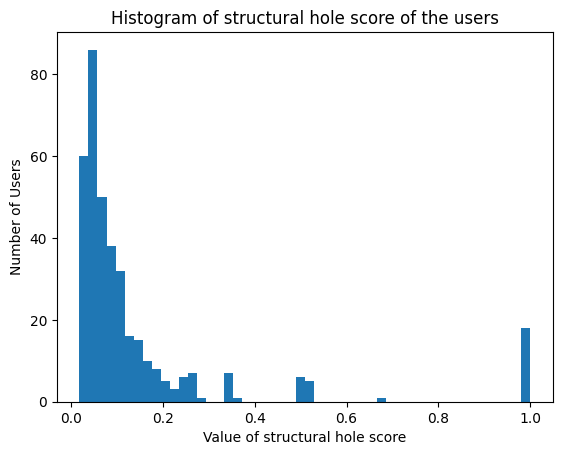

In [29]:
import matplotlib.pyplot as plt

#plots
plt.hist(score_arr, bins=50)
plt.xlabel('Value of structural hole score')
plt.ylabel('Number of Users')
plt.title('Histogram of structural hole score of the users')
plt.show()

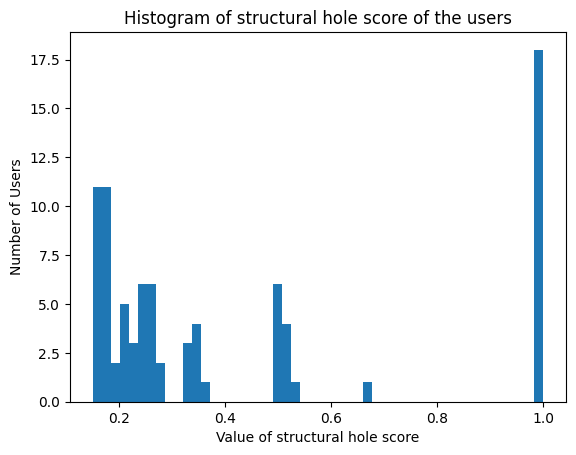

In [28]:
import matplotlib.pyplot as plt

#plots
plt.hist(ab_threshold, bins=50)
plt.xlabel('Value of structural hole score')
plt.ylabel('Number of Users')
plt.title('Histogram of structural hole score of the users')
plt.show()


# Betweeeness Centrality


In [24]:
import csv
import networkx as nx

# calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")

# calculate number of triangles each node belongs to
triangles = nx.triangles(G)

max_bwtncentr = max(betweenness_centrality.items(), key=lambda x: x[1])

# Print the maximum betweenness centrality value and node
print("Maximum betweenness centrality value: ", max_bwtncentr[1])
print("Node with maximum betweenness centrality: ", max_bwtncentr[0])

# write the results to a CSV file
with open('betweenness_centrality.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['username', 'betweenness_centrality', 'triangles'])
    for node in G.nodes():
        writer.writerow([node, betweenness_centrality[node], triangles[node]])


Maximum betweenness centrality value:  0.08948057803397362
Node with maximum betweenness centrality:  IM4ttthew
